# Google Drive Setup

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# NOTE: To be able to access the shared files, you need to go to Drive and click
# "Add shortcut to Drive" on the options for the shared folder to be able to access it when mounted

Mounted at /content/gdrive


In [2]:
# Paths to the "Project Code" folder
path_andrew = "/content/gdrive/MyDrive/CS 7643/Project/Project Code"
path_gillian = "/content/gdrive/MyDrive/CS 7643/Project Code"
path_blake = "/content/gdrive/MyDrive/CS 7643/Project Code"
path_isaac = "/content/gdrive/MyDrive/classes/CS 7643/Project Code"
path_bryan = "/content/gdrive/MyDrive/Georgia Tech/CS 7643/CS 7643/Project Code"

In [3]:
# change this to your path when running
path = path_andrew
%cd {path}

/content/gdrive/.shortcut-targets-by-id/1lmYZ9dBUQsLKZApoHNFRjbtE_VA1kGF4/CS 7643/Project Code


# Imports/Setup

In [4]:
# pip installs
!pip install transformers
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 10.2 MB/s eta 0:00:00


In [5]:
%load_ext autoreload
%autoreload 2

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torcheval.metrics.functional import binary_auroc

# data
from HMDataset import HMDataset, HMDataset_H5

# model
from transformers import BertModel, BertTokenizerFast
from ClassificationHead import BaseLineHead

# general
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [6]:
# gpu check
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device=='cuda')

2.0.0+cu118
False


In [7]:
# Hyperparameters
batch_size = 64
lr = 1e-4
epochs = 10
weight_decay = 1e-3


In [8]:
# dataloaders
transform = transforms.ToTensor() # everything in HDF5 is already pre-resized to 256 x 256  

train_dataset = HMDataset_H5(h5_file="./training_db.h5", transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# validation (for tracking performance during training)
validate_dataset = HMDataset_H5(h5_file="./validation_db.h5", transform=transform)
validate_dataloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# testing (for generating final performance metrics)
test_dataset = HMDataset_H5(h5_file="./test_db.h5", transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [9]:
print(len(test_dataset))
print(len(validate_dataset))

540
500


# ResNet Image Feature Extractor

In [10]:
resnet152 = models.resnet152(weights="ResNet152_Weights.DEFAULT", progress=True)

modules = list(resnet152.children())

resnet152_fe = nn.Sequential(*modules[:-1])

resnet152_fe.to(device)

for p in resnet152_fe.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 91.3MB/s]


# BERT For Text Encoding

In [11]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

model.to(device)

for param in model.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
head = BaseLineHead()
head.to(device)

BaseLineHead(
  (linear_stack): Sequential(
    (0): BatchNorm1d(2816, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2816, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [13]:
def get_metrics_and_losses(losses, predictions, labels):
  average_loss = losses.mean().item()
  accuracy = (predictions == labels).sum().item() / labels.numel()

  # print(predictions)
  # print(labels)
  auroc = binary_auroc(predictions, labels)

  return average_loss, accuracy, auroc

# Test on 1 Batch

In [14]:
sample_test = next(iter(test_dataloader))

torch.Size([64, 3, 256, 256])
tensor(14235, dtype=torch.int32)
rest in peace harambe
tensor(0)


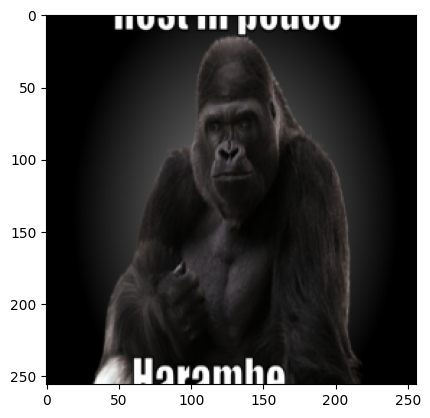

In [15]:
text = sample_test['text']
image = sample_test['image'].to(device)
labels = sample_test['label'].to(device).to(torch.int64)

id = sample_test["id"]

print(image.shape)

print(id[0])
print(text[0])
print(labels[0])
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))

In [16]:
sample_valid = next(iter(validate_dataloader))

torch.Size([64, 3, 256, 256])
tensor(67082, dtype=torch.int32)
"1st day of 4th grade sandy hook elementary school"
tensor(0)


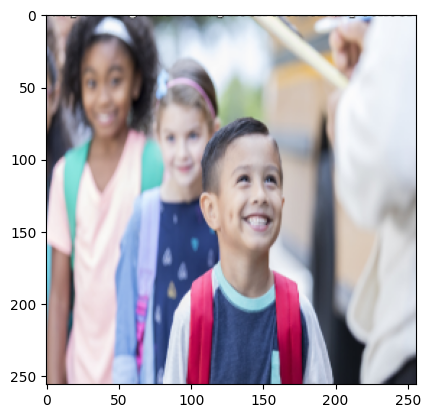

In [17]:
text = sample_valid['text']
image = sample_valid['image'].to(device)
labels = sample_valid['label'].to(device).to(torch.int64)

id = sample_valid["id"]

print(image.shape)

print(id[0])
print(text[0])
print(labels[0])
plt.imshow(image[0].cpu().detach().numpy().transpose(1, 2, 0))

In [22]:
sample_batch = next(iter(train_dataloader))


torch.Size([64, 3, 256, 256])
look at all these shooting targets
tensor(0)


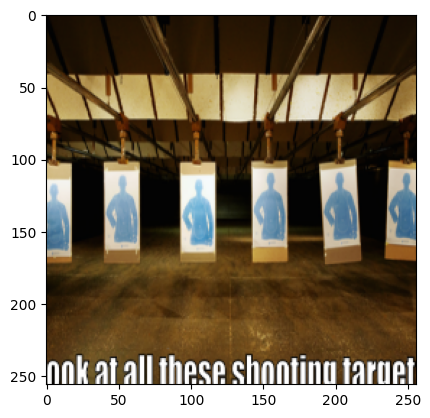

In [25]:
# get inputs
text = sample_batch['text']
image = sample_batch['image'].to(torch.int64).to(device)
labels = sample_batch['label'].to(device).to(torch.int64)

print(image.shape)

print(text[0])
print(labels[0])

plt.imshow(image[0].to(torch.int64).cpu().detach().numpy().transpose(1, 2, 0))

In [31]:
# Get Image Features


image = image.float()
image_features = resnet152_fe(image).squeeze()

print(image_features.shape)
print(image_features)

print(torch.max(image_features))
print(torch.min(image_features))

torch.Size([64, 2048])
tensor([[4.5143e-03, 0.0000e+00, 1.2387e-04,  ..., 0.0000e+00, 9.8826e-02,
         4.2032e-01],
        [0.0000e+00, 1.0670e-01, 0.0000e+00,  ..., 6.8070e-02, 0.0000e+00,
         1.1373e-01],
        [6.5569e-02, 1.4893e-02, 7.4038e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.1153e-01],
        ...,
        [7.5966e-01, 2.1233e-02, 9.5982e-02,  ..., 1.2468e+00, 1.9940e-01,
         1.8082e-01],
        [9.1043e-01, 0.0000e+00, 3.4398e-02,  ..., 4.1527e-01, 0.0000e+00,
         1.0690e-02],
        [1.6368e-01, 1.0603e-02, 3.8829e-01,  ..., 4.2314e-02, 1.1330e-01,
         1.1510e+00]])
tensor(9.8040)
tensor(0.)


In [32]:
# Get Text Features

tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
text_features = model(**tokenized_input)

print(text_features["pooler_output"].shape)
print(text_features["pooler_output"])

print(torch.max(text_features["pooler_output"]))
print(torch.min(text_features["pooler_output"]))

torch.Size([64, 768])
tensor([[-0.8198, -0.3234, -0.6467,  ..., -0.4314, -0.6375,  0.8252],
        [-0.8110, -0.3093, -0.5848,  ..., -0.2654, -0.5043,  0.8473],
        [-0.9028, -0.3668, -0.7072,  ..., -0.3270, -0.6282,  0.9258],
        ...,
        [-0.8410, -0.2482, -0.0014,  ...,  0.1064, -0.4895,  0.8773],
        [-0.7787, -0.4442, -0.9350,  ..., -0.7696, -0.5374,  0.8345],
        [-0.7957, -0.5673, -0.7422,  ..., -0.5705, -0.6066,  0.8264]])
tensor(1.)
tensor(-1.)


In [33]:
# concatenate both features

concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

print(concat_features.shape)
print(concat_features)

print(torch.min(concat_features))
print(torch.max(concat_features))

torch.Size([64, 2816])
tensor([[ 4.5143e-03,  0.0000e+00,  1.2387e-04,  ..., -4.3135e-01,
         -6.3753e-01,  8.2518e-01],
        [ 0.0000e+00,  1.0670e-01,  0.0000e+00,  ..., -2.6544e-01,
         -5.0431e-01,  8.4734e-01],
        [ 6.5569e-02,  1.4893e-02,  7.4038e-02,  ..., -3.2695e-01,
         -6.2822e-01,  9.2577e-01],
        ...,
        [ 7.5966e-01,  2.1233e-02,  9.5982e-02,  ...,  1.0640e-01,
         -4.8948e-01,  8.7729e-01],
        [ 9.1043e-01,  0.0000e+00,  3.4398e-02,  ..., -7.6961e-01,
         -5.3739e-01,  8.3446e-01],
        [ 1.6368e-01,  1.0603e-02,  3.8829e-01,  ..., -5.7046e-01,
         -6.0663e-01,  8.2640e-01]])
tensor(-1.)
tensor(9.8040)


In [34]:
batchnorm = nn.BatchNorm1d(2816).to(device)

normalized_features = batchnorm(concat_features)

In [35]:
print(normalized_features.shape)
print(normalized_features)

print(torch.min(normalized_features))
print(torch.max(normalized_features))

torch.Size([64, 2816])
tensor([[-7.4539e-01, -8.3107e-01, -6.9000e-01,  ..., -5.6067e-03,
          5.3490e-02, -7.8487e-02],
        [-7.6656e-01,  3.0176e-01, -6.9092e-01,  ...,  4.7541e-01,
          1.8590e+00,  1.1045e-01],
        [-4.5919e-01, -6.7295e-01, -1.3809e-01,  ...,  2.9707e-01,
          1.7966e-01,  7.7911e-01],
        ...,
        [ 2.7945e+00, -6.0563e-01,  2.5759e-02,  ...,  1.5534e+00,
          2.0600e+00,  3.6579e-01],
        [ 3.5013e+00, -8.3107e-01, -4.3408e-01,  ..., -9.8624e-01,
          1.4106e+00,  6.0725e-04],
        [ 7.3190e-04, -7.1849e-01,  2.2084e+00,  ..., -4.0889e-01,
          4.7224e-01, -6.8066e-02]], grad_fn=<NativeBatchNormBackward0>)
tensor(-7.7603, grad_fn=<MinBackward1>)
tensor(7.8867, grad_fn=<MaxBackward1>)


In [36]:
softmax = nn.Softmax(dim=-1)

In [37]:
scores = head(concat_features)

pred = scores.argmax(dim=-1)

print(scores)
print(pred)
print(labels)

tensor([[ 0.0235,  0.2971],
        [ 0.2965, -0.1200],
        [ 0.3080,  0.1555],
        [ 0.1393,  0.1038],
        [ 0.0821,  0.1177],
        [-0.0020,  0.2606],
        [ 0.0676, -0.0613],
        [-0.0458, -0.2432],
        [-0.3067,  0.1222],
        [-0.1537,  0.3598],
        [ 0.2905,  0.2831],
        [ 0.4029,  0.1309],
        [-0.0446,  0.0174],
        [ 0.1274, -0.0032],
        [ 0.0375, -0.0654],
        [ 0.3723,  0.2345],
        [ 0.3664,  0.1418],
        [ 0.0039,  0.0596],
        [ 0.2814, -0.1302],
        [-0.0933,  0.1966],
        [-0.0449,  0.2582],
        [-0.0975,  0.3740],
        [ 0.4797, -0.1901],
        [-0.0344,  0.2986],
        [ 0.2735, -0.2762],
        [-0.0956,  0.2539],
        [ 0.2691, -0.0223],
        [ 0.4076,  0.1211],
        [ 0.2354,  0.0037],
        [ 0.1630,  0.1500],
        [-0.0932,  0.1552],
        [ 0.1795, -0.0432],
        [ 0.2497,  0.3844],
        [ 0.3775, -0.1338],
        [-0.0566, -0.2625],
        [-0.0646,  0

# Train Model

In [ ]:
head = BaseLineHead()
head.to(device)

BaseLineHead(
  (linear_stack): Sequential(
    (0): BatchNorm1d(2816, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2816, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=2, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(head.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
loss = criterion(scores, labels)
print(loss)

loss, acc, auroc = get_metrics_and_losses(loss, pred, labels)

print(loss)
print(acc)
print(auroc)

tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
0.6931003928184509
0.53125
tensor(0.4955, device='cuda:0', dtype=torch.float64)


# Full Training Loop

In [ ]:
# train model head
max_validation_auroc = 0

for e in range(epochs):

  # training
  train_losses = torch.zeros(len(train_dataloader)).to(device)
  train_predictions = torch.Tensor().to(device)
  train_labels = torch.Tensor().to(device)

  resnet152_fe.train()
  model.train()
  head.train()

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc="Epoch " + str(e+1) + " Training"):

    # get inputs
    text = data['text']
    image = data['image'].to(device).float()
    labels = data['label'].to(device).to(torch.int64)

    # zero the parameter gradients
    optimizer.zero_grad()

    # print("pre-resnet")

    # ResNet Image Features
    image_features = resnet152_fe(image).squeeze()

    # print("after-resnet")
    # print("pre-BERT")

    # BERT Text Features
    tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
    text_features = model(**tokenized_input)

    # print("after-BERT")

    # Concatenate Features
    concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

    # print("pre-head")

    # classification head
    scores = torch.squeeze(head(concat_features))
    predictions = scores.argmax(dim=-1)

    # print("after-head")
    # print("pre-backprop")

    # backprop
    loss = criterion(scores, labels)
    loss.backward()
    optimizer.step()

    # print("after-backprop")

    # track values for metric logging
    train_losses[i] = loss
    train_predictions = torch.cat((train_predictions, predictions))
    train_labels = torch.cat((train_labels, labels))

    train_average_loss, train_accuracy, train_auroc = get_metrics_and_losses(train_losses, train_predictions, train_labels)

  # validation
  validate_losses = torch.zeros(len(validate_dataloader)).to(device)
  validate_predictions = torch.Tensor().to(device)
  validate_labels = torch.Tensor().to(device)
  
  resnet152_fe.eval()
  model.eval()
  head.eval()

  with torch.no_grad():
    for i, data in tqdm(enumerate(validate_dataloader), total=len(validate_dataloader), desc="Epoch " + str(e+1) + " Validation"):

      # get inputs
      # get inputs
      text = data['text']
      image = data['image'].to(device).float()
      labels = data['label'].to(device).to(torch.int64)

      # ResNet Image Features
      image_features = resnet152_fe(image).squeeze()

      # BERT Text Features
      tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
      text_features = model(**tokenized_input)

      # Concatenate Features
      concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

      # classification head
      scores = torch.squeeze(head(concat_features))
      predictions = scores.argmax(dim=-1)

      # loss
      loss = criterion(scores, labels)

      # track values for metric logging
      validate_losses[i] = loss
      validate_predictions = torch.cat((validate_predictions, predictions), dim=0)
      validate_labels = torch.cat((validate_labels, labels), dim=0)

  validate_average_loss, validate_accuracy, validate_auroc = get_metrics_and_losses(validate_losses, validate_predictions, validate_labels)

  # save model
  if validate_auroc > max_validation_auroc:
    max_validation_auroc = validate_auroc
    torch.save(head, "./models/concat_bert_" + str(e+1) + ".pt")
    print("New model saved at epoch " + str(e+1))

  print(train_predictions[:64])
  print(train_labels[:64])
  print(validate_predictions[:64])
  print(validate_labels[:64])

  print("Epoch %d" % (e+1))
  print("Training Loss: %.4f. Validation Loss: %.4f. " % (train_average_loss, validate_average_loss))
  print("Training Accuracy: %.4f. Validation Accuracy: %.4f. " % (train_accuracy, validate_accuracy))
  print("Training AUROC: %.4f. Validation AUROC: %.4f. " % (train_auroc, validate_auroc))
  print("-----------------------------------")


  # looks promising on training - failing to generalize = overfitting
  # add batchnorm (done)
  # inc dropout (done)
  # remove middle layer (not much effect - try reducing hidden size)
  # add weight decay - essentialy explicit L2 regularization -> **best results so far**
  # implement early stopping
  # incr to 20 epochs? -> 40 mins to train...

  # try without sigmoid - maybe better

Epoch 1 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


New model saved at epoch 1
tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 0., 0., 1.], device='cuda:0')
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.,

Epoch 2 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


New model saved at epoch 2
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,

Epoch 3 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


New model saved at epoch 3
tensor([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
        0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 0., 1., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,

Epoch 4 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


New model saved at epoch 4
tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,

Epoch 5 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


New model saved at epoch 5
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 1., 0., 0., 0., 1., 0., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,

Epoch 6 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


tensor([0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 1.], device='cuda:0')
tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
  

Epoch 7 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 1., 1.], device='cuda:0')
tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0.,
  

Epoch 8 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


tensor([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')
tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
        1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0')
tensor([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
  

Epoch 9 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


tensor([0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 0.], device='cuda:0')
tensor([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
  

Epoch 10 Validation: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 0.], device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
  

In [ ]:
resnet152_fe.eval()
model.eval()
head.eval()

with torch.no_grad():
  test_losses = torch.zeros(len(test_dataloader)).to(device)
  test_predictions = torch.Tensor().to(device)
  test_labels = torch.Tensor().to(device)

  for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), desc="Test Model"):

    # get inputs
    text = data['text']
    image = data['image'].to(device).float()
    labels = data['label'].to(device).to(torch.int64)

    # ResNet Image Features
    image_features = resnet152_fe(image).squeeze()

    # BERT Text Features
    tokenized_input = tokenizer(text, padding=True, return_tensors="pt").to(device)
    text_features = model(**tokenized_input)

    # Concatenate Features
    concat_features = torch.cat((image_features, text_features["pooler_output"]), dim=1)

    # classification head
    scores = torch.squeeze(head(concat_features))
    predictions = scores.argmax(dim=-1)

    # loss
    loss = criterion(scores, labels)

    # track values for metric logging
    test_losses[i] = loss
    test_predictions = torch.cat((test_predictions, predictions), dim=0)
    test_labels = torch.cat((test_labels, labels), dim=0)

  test_average_loss, test_accuracy, test_auroc = get_metrics_and_losses(test_losses, test_predictions, test_labels)


  print(test_predictions[:64])
  print(test_labels[:64])

  print("Test Loss: %.4f." % (test_average_loss))
  print("Test Accuracy: %.4f." % (test_accuracy))
  print("Test AUROC: %.4f." % (test_auroc))
  print("-----------------------------------")

Test Model: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 0., 0., 0., 0., 1.], device='cuda:0')
tensor([1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 0., 1., 0., 1., 0., 0., 0., 1., 1.], device='cuda:0')
Test Loss: 0.8980.
Test Accuracy: 0.5852.
Test AUROC: 0.5213.
-----------------------------------
